# Text factual query using Word2Vec with TensorFlow

## Intro

We can take words in a language as independent set of characters and define their meaning individually. Even though that works for basic meaning, the relationship between each of the words are lost. So, we need to convert them into a space or representation that is easy to manipulate while inter-relational features are preserved. Vector representations are the most commonly used construct for this purpose in Mathematics. Thus, _word embedding_ is a process of mapping of words (or phrases) from the vocabulary to vectors of real numbers. TensorFlow's [Word2Vec](https://www.tensorflow.org/tutorials/word2vec) model is widely used for this purpose. 

### Suggested readings:
* To understand better Skip-Gram Model the following tutorial is suggested
 - [Word2Vec Tutorial - The Skip-Gram Model](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)

* To know about more complex and effective implementations of word2vec models see

 - [Distributed Representations of Words and Phrases and their Compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)

Now let's start by trying to convert three sentences to dense vectors. As explained by [Word2Vec](https://www.tensorflow.org/tutorials/word2vec) that [Distributional Hypothesis](https://en.wikipedia.org/wiki/Distributional_semantics#Distributional_Hypothesis) relies on the assumption that words appearing in the same context probably share the semantic meaning. Dense calculations compared to sparse calculations are more efficient so using vectors allow words of similar meaning to appear near each other. Go ahead and run the next cell to get started by importing the necessary libraries and setting the basic sentences for us to work with.

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from collections import defaultdict
%matplotlib inline


# Let's for example consider a simple way to map words from sentences into dense vectors.
# Let's make a table with words coocurrencies and then project vectors of all words into 2D using PCA.

s = ['Sky is blue', 'She is getting better', 'Everything is possible']
dic = defaultdict(dict)
for sent in s:
    words = sent.split()
    for w in words:
        for w2 in words:
            dic[w][w2]=1

df = pd.DataFrame(dic)
df.fillna(0, inplace=True)
df

/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


,Everything,She,Sky,better,blue,getting,is,possible
Everything,1.0,0.0,0.0,0.0,0.0,0.0,1,1.0
She,0.0,1.0,0.0,1.0,0.0,1.0,1,0.0
Sky,0.0,0.0,1.0,0.0,1.0,0.0,1,0.0
better,0.0,1.0,0.0,1.0,0.0,1.0,1,0.0
blue,0.0,0.0,1.0,0.0,1.0,0.0,1,0.0
getting,0.0,1.0,0.0,1.0,0.0,1.0,1,0.0
is,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0
possible,1.0,0.0,0.0,0.0,0.0,0.0,1,1.0


You will see the vector space created by every word in each sentence. If they appear in the same sentence then the weight is 1. If they do not appear in the same sentence then it's at 0. The table basically gives relations between of the words given the 3 context sentences.

Now go ahead and run the next cell to collapse the words relationship into smaller dimensions so you'll see the clustering.

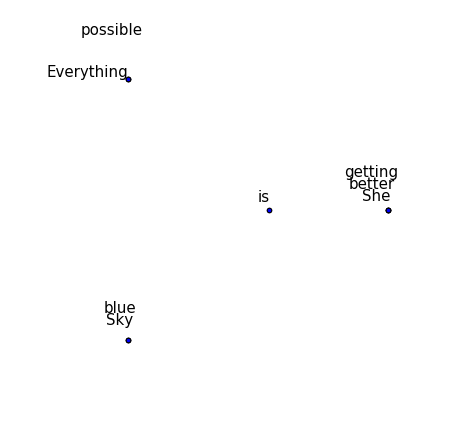

In [3]:
res = PCA().fit_transform(df)

font = {'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(7,7))
plt.scatter(res[:,0], res[:,1])
plt.axis('off')
for i, label in enumerate(df.columns):
    x, y = res[i,0], res[i,1]
    plt.scatter(x, y)
    annot = {'has': (1, 50), 'is': (1, 5)}
    plt.annotate(label, xy=(x, y),
                 xytext=annot.get(label,(1+i*2, 6*i)), 
                 textcoords='offset points',
                   ha='right', va='bottom', )

### Exercise 1

Q. Why is the word 'is' by itself?

# word2vec: skip gram & cbow

Models __CBOW (Continuous Bag of Words)__ and __Skip gram__ were invented in the now distant 2013,
*article*:
[*Tomas Mikolov et al.*](https://arxiv.org/pdf/1301.3781v3.pdf)

* __CBOW__ model predict missing word (focus word) using context (surrounding words).
* __skip gram__ model is reverse to _CBOW_. It predicts context based on the word in focus.

* **Context** is a fixed number of words to the left and right of the word in focus (see picture below). The length of the context is defined by the "window" parameter.

![context](pics/context.png)

Two models comparision

![architecture](pics/architecture.png)

___

There are a lot of implementations of word2vec e.g. [gensim](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/word2vec.ipynb).
And there are a lot of trained word-vectors which are already ready to use. But today we will learn how to create your own word embeddings.
___


### Skip-gram

Consider a corpus with a sequence of words $ w_1, w_2, .., w_T $.

Objective function (we would like to maximize it) for _skip gram_ is defined as follow:


$$ AverageLogProbability = \frac{1}{T} \sum_{t=1}^{T} \sum_{-c \leqslant j\leqslant c, j \neq 0} log\ p (w_{t+j} | w_t) $$

* where $ c $ is a context length.
* $w_t$ -- focus word

The basic formulation for probability $ p (w_{t+j} | w_t) $ is calculated using __Softmax__ -

$$ p (w_o | w_i) = \frac{exp(s(v_i, v_o))}{ \sum^{W}_{w=1}  exp(s(v_{w}, v_{i} )) } $$

where
* $v_i$ and $v_o$ input and output vector representations of $w_i$, $w_o$ .
* $s(v_i, v_o) = v^{T} _{o} \cdot v_{i}$
* $W$ is the number of words in vocabulary

___

### CBOW

Predict word using context.

$$ E = -log\ p(w_o\ |\ w_{1},\ w_{2},\ \dots,\ w_{c}) $$


The **probability** is the same as in the *skip gram* model, but now $v_i$ is a sum of context-word vectors.

$$ p(w_o\ |\ w_{1},\ w_{2},\ \dots,\ w_{c})  = \frac{exp(s(v_i, v_o))}{\sum^{W}_{w=1}  exp(s(v_{w}, v_{i} ))} $$


* $\ w_{1},\ w_{2},\ \dots,\ w_{c}$ -- input context words
* $ v_i = \sum^{c}_{k=1} w_{k}$
* $ v_o$ = vector of output word
* $s(v_i, v_o) = v^{T} _{o} \cdot v_{i}$

___

Let's implement __`CBOW`__ using tf framework.

And then implement __`skip gram`__ using CBOW implementation as an example.
___

First import TensorFlow as we did with other libraries

In [1]:
import tensorflow as tf

We will be using [text8 dataset](http://mattmahoney.net/dc/textdata).

It's a 100 Mb dump of English Wikipedia site at the time of March 3, 2006. It gives us a rich dataset to work with while the size isn't too big yet. 

# Working with data

First we need to prepare the data so we can process it easily. One issue in NLP is the text corpus we have to deal with are usually long. Let's fetch the data but ensure that it's done only once.

In [3]:
# WARNING! if this file "./data/text8.zip" doesn't exist
# it will be downloaded right now.

import os, urllib.request
def fetch_data(url):
    
    filename = url.split("/")[-1]
    datadir = os.path.join(os.getcwd(), "data")
    filepath = os.path.join(datadir, filename)
    
    if not os.path.exists(datadir):
        os.makedirs(datadir)
    if not os.path.exists(filepath):
        urllib.request.urlretrieve(url, filepath)
    
    return filepath

url = "http://mattmahoney.net/dc/text8.zip"
filepath = fetch_data(url)
print ("Data at {0}.".format(filepath))

Data at /home/azeltov/notebooks/GPUTechConf/data/text8.zip.


Then unzip and read the data file.

In [4]:
import os, zipfile

def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data


words = read_data(filepath)
print("data_size = {0}".format(len(words)))

data_size = 17005207


Only the first 50K more frequently used words are considered here N = 50000. The rest of the words are marked with unknow token "UNK".

In [5]:
from collections import Counter

def build_dataset(words, vocabulary_size):
    count = [[ "UNK", -1 ]]
    count.extend(Counter(words).most_common(vocabulary_size-1))
    print("Least frequent word: ", count[-1])
    word_to_index = { word: i for i, (word, _) in enumerate(count) }
    data = [word_to_index.get(word, 0) for word in words] # map unknown words to 0
    unk_count = data.count(0) # Number of unknown words
    count[0][1] = unk_count
    index_to_word= dict(zip(word_to_index.values(), word_to_index.keys()))
    
    return data, count, word_to_index, index_to_word

vocabulary_size = 50000
data, count, word_to_index, index_to_word = build_dataset(words, vocabulary_size)

# Everything you need to know about the dataset

print("data: {0}".format(data[:5]))
print("count: {0}".format(count[:5]))
print("word_to_index: {0}".format(list(word_to_index.items())[:5]))
print("index_to_word: {0}".format(list(index_to_word.items())[:5]))

Least frequent word:  ('buttstock', 9)
data: [5242, 3081, 12, 6, 195]
count: [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
word_to_index: [('cfa', 11990), ('charleroi', 42952), ('rao', 29936), ('hussars', 42622), ('derisively', 34380)]
index_to_word: [(0, 'UNK'), (1, 'the'), (2, 'of'), (3, 'and'), (4, 'one')]


### Exercise 2

Let's look at characteristics of the wiki dataset.

Q. How many 'unknown' occurrences are there? 

Q. Which word has the highest occurrences?

Q. What is the index for that word? 

Now that we know the characteristics of the dataset, let's batch up the data and start processing. 

In [6]:
import numpy as np
from collections import deque

def generate_batch(data_index, data_size, batch_size, bag_window):
    span = 2 * bag_window + 1 # [ bag_window, target, bag_window ]
    batch = np.ndarray(shape = (batch_size, span - 1), dtype = np.int32)
    labels = np.ndarray(shape = (batch_size, 1), dtype = np.int32)
    
    data_buffer = deque(maxlen = span)
    
    for _ in range(span):
        data_buffer.append(data[data_index])
        data_index = (data_index + 1) % data_size
        
    for i in range(batch_size):
        data_list = list(data_buffer)
        labels[i, 0] = data_list.pop(bag_window)
        batch[i] = data_list
        
        data_buffer.append(data[data_index])
        data_index = (data_index + 1) % data_size
    return data_index, batch, labels


print("data = {0}".format([index_to_word[each] for each in data[:16]]))
data_index, data_size, batch_size = 0, len(data), 4
for bag_window in [1, 2]:
    _, batch, labels = generate_batch(data_index, data_size, batch_size, bag_window)
    print("bag_window = {0}".format(bag_window))
    print("batch = {0}".format([[index_to_word[index] for index in each] for each in batch]))
    print("labels = {0}\n".format([index_to_word[each] for each in labels.reshape(4)]))

data = ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the']
bag_window = 1
batch = [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of']]
labels = ['originated', 'as', 'a', 'term']

bag_window = 2
batch = [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first']]
labels = ['as', 'a', 'term', 'of']



And now just take a close look at the output.

* We just want to implement _CBOW_, and therefore missed words are considered as the `labels`.

* Remember about the __window__ parameter discussed above, here it is __`bag_window`__.

* Each sample in the batch has a number of words equal to __`bag_window * 2`__
___

# CBOW architecture

Let's start implementing CBOW architecture. Pay close attention to each of the steps as you'll be having to replicate the process for skip-gram model. The two processes should be very similar to each other. 


In [7]:
import math

# define constants
batch_size = 256
embedding_size = 128

# How many words to consider from each side
bag_window = 2

tf.reset_default_graph()
graph = tf.Graph()
with graph.as_default():
    #
    # Take the vectors for the context words, which are all bag_window * 2
    train_data = tf.placeholder(tf.int32, [batch_size, bag_window * 2])
    # Label -- is a word in focus
    train_labels = tf.placeholder(tf.int32, [batch_size])
    
    #
    # Create an embedding matrix
    # and initialize it by sampling from the uniform distribution [-1, 1]
    
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    
    #
    # Get vectors corresponding to the indices of context words
    # embed is a matrix with shape [batch_size, bag_window * 2, embedding_size]
    embed = tf.nn.embedding_lookup(embeddings, train_data)
    
    # Sum up all the context vectors to the one vector with the same dimension
    # Here we got a matrix of such vectors with the shape [batch_size, embedding_size]
    context_sum = tf.reduce_sum(embed, 1)
    
    scores = tf.matmul(context_sum, embeddings, transpose_b=True)
    
    one_hot_labels = tf.one_hot(train_labels, vocabulary_size)
    loss_tensor = tf.losses.softmax_cross_entropy(onehot_labels=one_hot_labels, logits=scores)
    loss = tf.reduce_mean(loss_tensor)

    
    optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
    
    # We need to normalize word embeddings for dot product to be a cosine distance 
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims = True))
    normalized_embeddings = embeddings / norm

# Training CBOW model

For 8k steps on 2 physical CPU cores it takes about 18 minutes.

Unfortunately, it is not enough to train good embeddings.

Luckily, we have GPU available in this lab, so you could try to achieve reasonable quality much faster. Good representations should take over 50k iterations. Now go ahead and run it to train the model.

In [8]:
%%time
#num_steps = 50001
num_steps = 8001

with tf.Session(graph=graph) as sess:
    try:
        tf.global_variables_initializer().run()
        print('Initialized')
        average_loss = 0

        for step in range(num_steps):
            data_index, batch, labels = generate_batch(data_index, data_size, batch_size, bag_window)
            feed_dict = { train_data: batch, train_labels: labels.reshape(-1) }
            _, current_loss = sess.run([optimizer, loss], feed_dict = feed_dict)
            average_loss += current_loss
            if step % 10 == 0:
                if step > 0:
                    average_loss = average_loss / 10
                    print ("step = {0}, average_loss = {1}".format(step, average_loss))
                    average_loss = 0
    except KeyboardInterrupt:
        final_embeddings = normalized_embeddings.eval()
    final_embeddings = normalized_embeddings.eval()

Initialized
step = 10, average_loss = 52.250392532348634
step = 20, average_loss = 44.206346893310545
step = 30, average_loss = 42.91114616394043
step = 40, average_loss = 42.24429588317871
step = 50, average_loss = 38.82651863098145
step = 60, average_loss = 39.42842903137207
step = 70, average_loss = 37.10111351013184
step = 80, average_loss = 38.34696159362793
step = 90, average_loss = 35.27047996520996
step = 100, average_loss = 32.59425315856934
step = 110, average_loss = 31.813234519958495
step = 120, average_loss = 31.362119483947755
step = 130, average_loss = 28.323558616638184
step = 140, average_loss = 30.328146743774415
step = 150, average_loss = 27.845433044433594
step = 160, average_loss = 28.64184627532959
step = 170, average_loss = 29.361812591552734
step = 180, average_loss = 25.76127815246582
step = 190, average_loss = 26.306490898132324
step = 200, average_loss = 24.7330753326416
step = 210, average_loss = 24.741089057922363
step = 220, average_loss = 23.5789485931396

step = 1790, average_loss = 8.531888103485107
step = 1800, average_loss = 7.737627267837524
step = 1810, average_loss = 10.191238498687744
step = 1820, average_loss = 11.156056976318359
step = 1830, average_loss = 9.362171268463134
step = 1840, average_loss = 10.140424728393555
step = 1850, average_loss = 10.42140064239502
step = 1860, average_loss = 8.724186182022095
step = 1870, average_loss = 9.36388602256775
step = 1880, average_loss = 10.07512936592102
step = 1890, average_loss = 11.256389284133911
step = 1900, average_loss = 9.086041450500488
step = 1910, average_loss = 9.85124683380127
step = 1920, average_loss = 9.62615213394165
step = 1930, average_loss = 9.759045934677124
step = 1940, average_loss = 9.231600379943847
step = 1950, average_loss = 8.818677616119384
step = 1960, average_loss = 9.825588989257813
step = 1970, average_loss = 9.47892198562622
step = 1980, average_loss = 8.711199378967285
step = 1990, average_loss = 8.441710567474365
step = 2000, average_loss = 7.4903

step = 3580, average_loss = 6.754859590530396
step = 3590, average_loss = 6.417992782592774
step = 3600, average_loss = 6.193999242782593
step = 3610, average_loss = 5.552353382110596
step = 3620, average_loss = 6.708011531829834
step = 3630, average_loss = 7.149765539169311
step = 3640, average_loss = 5.924002599716187
step = 3650, average_loss = 8.164339733123779
step = 3660, average_loss = 8.12777600288391
step = 3670, average_loss = 8.023569107055664
step = 3680, average_loss = 8.331098318099976
step = 3690, average_loss = 7.900778532028198
step = 3700, average_loss = 5.741504812240601
step = 3710, average_loss = 8.604466772079467
step = 3720, average_loss = 7.717994642257691
step = 3730, average_loss = 7.6858069896698
step = 3740, average_loss = 8.61709542274475
step = 3750, average_loss = 8.049810647964478
step = 3760, average_loss = 7.544842290878296
step = 3770, average_loss = 7.642765760421753
step = 3780, average_loss = 7.240183782577515
step = 3790, average_loss = 7.62355895

step = 5370, average_loss = 7.769568634033203
step = 5380, average_loss = 7.257882118225098
step = 5390, average_loss = 6.936125040054321
step = 5400, average_loss = 7.803335475921631
step = 5410, average_loss = 7.743523216247558
step = 5420, average_loss = 8.061302852630615
step = 5430, average_loss = 8.455048847198487
step = 5440, average_loss = 7.852118492126465
step = 5450, average_loss = 6.042690849304199
step = 5460, average_loss = 6.409756994247436
step = 5470, average_loss = 7.984224653244018
step = 5480, average_loss = 7.601601886749267
step = 5490, average_loss = 7.793040084838867
step = 5500, average_loss = 7.362072467803955
step = 5510, average_loss = 6.96499342918396
step = 5520, average_loss = 8.026385736465453
step = 5530, average_loss = 7.7528928279876705
step = 5540, average_loss = 7.466851091384887
step = 5550, average_loss = 8.151687860488892
step = 5560, average_loss = 6.923771953582763
step = 5570, average_loss = 7.3294031620025635
step = 5580, average_loss = 6.660

step = 7160, average_loss = 7.764245557785034
step = 7170, average_loss = 7.6562761783599855
step = 7180, average_loss = 6.582985353469849
step = 7190, average_loss = 5.862012338638306
step = 7200, average_loss = 5.831197118759155
step = 7210, average_loss = 7.672051668167114
step = 7220, average_loss = 8.287201118469238
step = 7230, average_loss = 8.061772775650024
step = 7240, average_loss = 8.215698766708375
step = 7250, average_loss = 8.109912729263305
step = 7260, average_loss = 7.746021175384522
step = 7270, average_loss = 7.915688323974609
step = 7280, average_loss = 7.101494264602661
step = 7290, average_loss = 6.799279594421387
step = 7300, average_loss = 6.930654287338257
step = 7310, average_loss = 7.509100008010864
step = 7320, average_loss = 7.930093002319336
step = 7330, average_loss = 8.215286493301392
step = 7340, average_loss = 7.792772483825684
step = 7350, average_loss = 8.042480230331421
step = 7360, average_loss = 7.677431392669678
step = 7370, average_loss = 7.583

# Visualization

We can use [projector](http://projector.tensorflow.org/) to visualize the results in a word cloud. Go ahead and click on [projector](http://projector.tensorflow.org/) to launch the visualization.

### Click on [Projector](http://projector.tensorflow.org/)


In [9]:
with open('embeddings.txt', 'w') as f:
    for n in range(vocabulary_size):
        s = '\t'.join([index_to_word[n]] + [str(num) for num in final_embeddings[n]])
        f.write(s + '\n')
with open('mentadata.txt', 'w') as f:
    for n in range(vocabulary_size):
        f.write(index_to_word[n] + '\n')

Or see TSNE here:

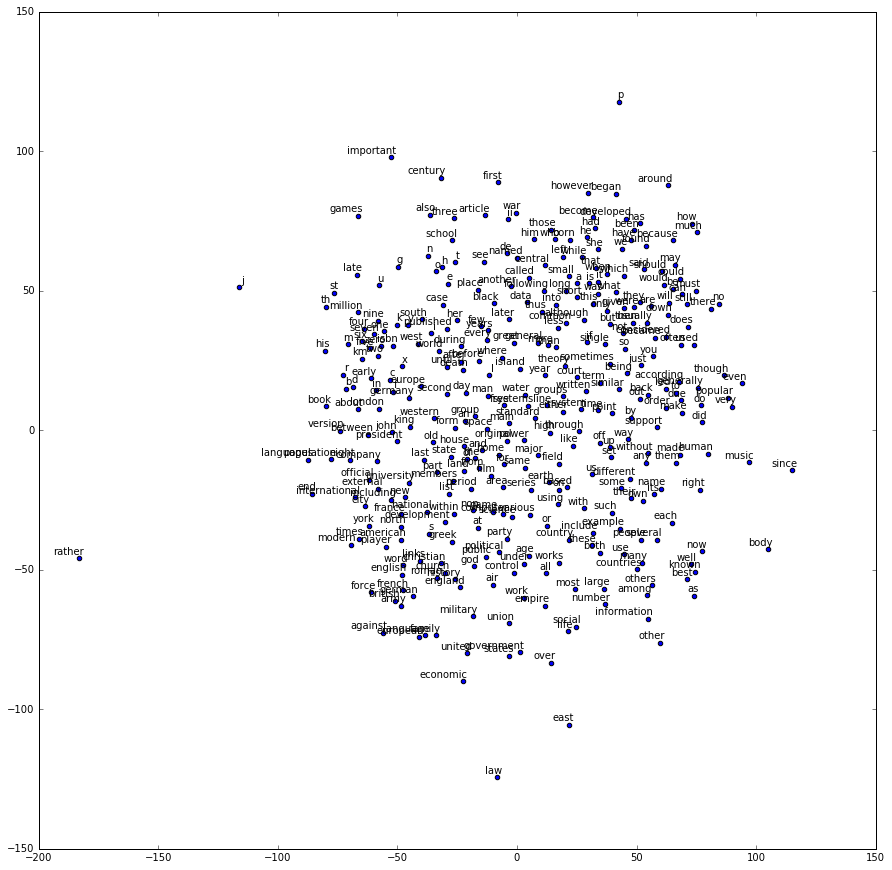

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


num_points = 350

tsne = TSNE(perplexity=10, n_components=2, init="pca", n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

plt.figure(figsize=(15,15))
words = [index_to_word[i] for i in range(1, num_points+1)]

for i, label in enumerate(words):
    x, y = two_d_embeddings[i, :]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords="offset points",
                   ha="right", va="bottom")
plt.show()

# Task

Your task is to implement `skip-gram` model, using code above.

This approach is nicely illustrated with this figure:

![skip_gram](./pics/training_data.png)
As you can see on the picture, the training set consists of pairs (`central word`, `context word`).

I.e. our model takes `central word` and should produce class in softmax, which corresponds to `context word`.

The difference between two models is not that big after all, so good luck with coding!

In [ ]:
# We have implemented batch generator for you
from collections import deque
import numpy as np
import random

def generate_batch_2(data_index, data_size, batch_size, num_skips, skip_window):
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape = batch_size, dtype = np.int32)
    labels = np.ndarray(shape = (batch_size, 1), dtype = np.int32)
    span = 2 * skip_window + 1
    data_buffer = deque(maxlen = span)
    for _ in range(span):
        data_buffer.append(data[data_index])
        data_index = (data_index + 1) % data_size
    
    for i in range(batch_size // num_skips):
        target, targets_to_avoid = skip_window, [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid: 
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = data_buffer[skip_window]
            labels[i * num_skips + j, 0] = data_buffer[target]
        data_buffer.append(data[data_index])
        data_index = (data_index + 1) % data_size
    return data_index, batch, labels


print ("data = {0}\n".format([index_to_word[each] for each in data[:32]]))
data_index, data_size = 0, len(data)
for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    data_index, batch, labels = generate_batch_2(data_index=data_index, 
                                               data_size=data_size, 
                                               batch_size=16, 
                                               num_skips=num_skips, 
                                               skip_window=skip_window)
    print ("data_index = {0}, num_skips = {1}, skip_window = {2}".format( data_index, num_skips, skip_window))
    print ("batch = {0}".format([index_to_word[each] for each in batch]))
    print ("labels = {0}\n".format([index_to_word[each] for each in labels.reshape(16)]))

Now that we have shown how to implement CBOW model, you have all the tools to create skip-gram model yourself. In the following cell, create skip-gram model by following the steps from CBOW implementation.

### Exercise 3
Fill-in the following cell with TensorFlow code for skip-gram model.

### Exercise 4
Once the model is created, next step is train it. Fill-in Tensorflow code for training of skip-gram model.

### Exercise 5
Finally, after training we want to visualize the results. Implement tSNE visualization of embeddings for skip-gram model.

## Real example

Let's test our embeddings on some real case: we create simple Wikipedia search engine. 

To do that first of all we need to download Wikipedia sample:

In [13]:
! wget -c "https://s3.amazonaws.com/fair-data/starspace/wikipedia_devtst.tgz"

--2018-03-25 21:37:52--  https://s3.amazonaws.com/fair-data/starspace/wikipedia_devtst.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.20.51
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.20.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34419187 (33M) [application/gzip]
Saving to: ‘wikipedia_devtst.tgz’

wikipedia_devtst.tg 100%[===================>]  32.82M   105MB/s    in 0.3s    

2018-03-25 21:37:53 (105 MB/s) - ‘wikipedia_devtst.tgz’ saved [34419187/34419187]



In [14]:
! tar -xzvf wikipedia_devtst.tgz

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
wikipedia_dev10k.txt
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
wikipedia_dev_basedocs.txt
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
wikipedia_test_basedocs.txt
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header ke

In [21]:
! head wikipedia_test_basedocs.txt 

OMV Rally Team	OMV World Rally Team was a name used by several different World Rally Championship teams and entrants in the 2000s : the Kronos Racing ( 2005 , 2007 ) ; and Bozian Racing ( 2006 ) .	The name was derived from commercial sponsorship arrangements , with financial support of OMV company .	Mostly in support for Manfred Stohl .
Park Jun-gyeong	Park Jun-gyeong ( ; born 22 January , 1993 ) is a South Korean footballer who currently plays for American team Colorado Springs Switchbacks in the United Soccer League .	Park signed with United Soccer League side Real Monarchs SLC on 8 February , 2016 .
Adaševci	Adaševci ( ) is a village located in Syrmia , Vojvodina , Serbia .	It is situated in the Šid municipality , in the Syrmia District .	The village has a Serb ethnic majority and its population numbering 2,166 people ( 2002 census ) .	Adaševci is located 5 kilometers south of Šid , in large part on the west side bordering the river Bosut , near the village there is an internat

Now we will vectorize all the articles:

In [16]:
def vectorize(text):
    tokens = text.lower().split()
    num_words = 0
    doc_vector = np.zeros_like(final_embeddings[0])
    for token in tokens: 
        if token in word_to_index:
            num_words += 1
            doc_vector += final_embeddings[word_to_index[token]]
    doc_vector /= num_words
    return doc_vector

In [17]:
vectorized_docs = []
docs = []
with open("wikipedia_test_basedocs.txt",encoding='utf8') as f:
    for doc in f:
        doc_vector = vectorize(doc)
        vectorized_docs.append(doc_vector)
        docs.append(doc)

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


Our toy search engine:

In [18]:
def search(query):
    query_vector = vectorize(query)
    ranking = []
    for i in range(len(vectorized_docs)):
        score = np.dot(query_vector, vectorized_docs[i])
        ranking.append((score, i))
    ranking.sort(key=lambda x: -x[0]) # to have descending sorting
    return docs[ranking[0][1]]

And at last we could test it on some query:

In [19]:
query = "japanese strong gull"

In [20]:
search(query)

'1995 in Japanese football\tJapanese football in 1995\n'

### Exercise 6

Create your own query and determine the quality of the results.

You could spot that results are not the best, so you could improve quality of the embeddings, by increasing windows size in training, increasing batch size and train longer.